# Exploratory data analysis of crowdsourcing results

# 0. Import dependencies and inputs

In [1]:
%run ../notebook_preamble_Transitions.ipy
from scipy.stats import pearsonr, spearmanr
import mapping_career_causeways.plotting_utils as plotting_utils
from sklearn.metrics import pairwise_distances
from scipy.stats import percentileofscore
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval


In [2]:
# Crowdsourcing dataset
inputs_folder = f'{data_folder}processed/validation/'

batch_1 = pd.read_csv(inputs_folder + 'Transitions_to_validate_BATCH_1.csv')
batch_2 = pd.read_csv(inputs_folder + 'Transitions_to_validate_BATCH_2.csv')
batch = pd.concat([batch_1, batch_2], axis=0)

# Crowd feasibility ratings
batch_results = pd.read_csv(inputs_folder + 'crowd_feasibility_ratings.csv', low_memory=False)

# Occupation similarity matrices
sims = load_data.Similarities()

# Location for exporting the processed data
figure_folder = useful_paths.codebase_dir + 'reports/crowd_feasibility_ratings/figures/'

In [3]:
batch_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70359 entries, 0 to 70358
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   classification_id                 70359 non-null  int64 
 1   subject_ids                       70359 non-null  int64 
 2   origin_id                         70359 non-null  int64 
 3   origin_label                      70359 non-null  object
 4   origin_description                70359 non-null  object
 5   destination_id                    70359 non-null  int64 
 6   destination_label                 70359 non-null  object
 7   destination_description           70359 non-null  object
 8   perfectly_matched_skills          59402 non-null  object
 9   partially_matched_skills          53095 non-null  object
 10  unmatched_skills                  69501 non-null  object
 11  familiarity_with_origin_1-5       70359 non-null  int64 
 12  familiarity_with_d

In [4]:
# Check that there are no duplicates
assert(len(batch_results.drop_duplicates(['classification_id'])) == len(batch_results))
assert(len(batch_results.drop_duplicates(['subject_ids', 'coder_id'])) == len(batch_results))

# 1. Contributors

## 1.1 Contributor characteristics

In [5]:
# Unique contributors
coder_df = batch_results.drop_duplicates('coder_id').copy()
# Number of unique contributors
N = len(coder_df)
print(N)

387


In [6]:
# How many 'questionable' coders? (who have markedly different opinions from the rest of the group)
coder_df = batch_results.drop_duplicates('coder_id')
coder_df.groupby('questionable_respondant_flag').agg({'coder_id': 'count'})

,coder_id
questionable_respondant_flag,
False,377
True,10


### Contributor gender

In [7]:
gender_breakdown = coder_df.groupby('gender').agg({'coder_id': 'count'})
gender_breakdown

,coder_id
gender,
Female,151
Male,234
Prefer not to say,1
Prefer to self-describe,1


In [8]:
gender_breakdown.loc['Male', 'coder_id'] / N

0.6046511627906976

In [9]:
gender_breakdown.loc['Female', 'coder_id'] / N

0.39018087855297157

### Contributor qualifications

In [10]:
# Qualifications
coder_df.groupby('highest_qualification').agg({'coder_id': 'count'}).sort_values('coder_id')

,coder_id
highest_qualification,
Master'degree,8
Doctorate,9
Bachelor'degree,10
Higher National Certificate,20
Higher National Diploma,24
GCSE,30
A-Level,62
Master's degree,72
Bachelor's degree,152


In [11]:
coder_df.highest_qualification.unique()

array(["Master'degree", "Bachelor's degree", 'Doctorate', 'GCSE',
       'A-Level', "Master's degree", 'Higher National Diploma',
       "Bachelor'degree", 'Higher National Certificate'], dtype=object)

In [12]:
def rename_qual(x):
    rename_dict = {"Master'degree": "Master's degree", "Bachelor'degree": "Bachelor's degree"}
    if x in rename_dict.keys():
        return rename_dict[x]
    else:
        return x
    

In [13]:
coder_df['highest_qualification'] = coder_df['highest_qualification'].apply(lambda x: rename_qual(x))

/Users/karliskanders/opt/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [14]:
qualifications = coder_df.groupby('highest_qualification').agg({'coder_id': 'count'}).sort_values('coder_id')
qualifications

,coder_id
highest_qualification,
Doctorate,9
Higher National Certificate,20
Higher National Diploma,24
GCSE,30
A-Level,62
Master's degree,80
Bachelor's degree,162


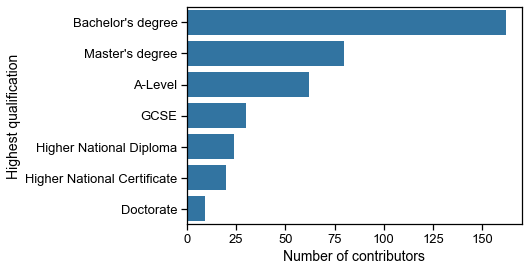

In [15]:
plt.figure(figsize=(6,4))
sns.barplot(data=qualifications.reset_index().sort_values('coder_id', ascending=False), y='highest_qualification', x='coder_id', color='C0')
plt.ylabel('Highest qualification')
plt.xlabel('Number of contributors')
plotting_utils.export_figure('contributors_qualifications', figure_folder=figure_folder, png=True, svg=True)

### Contributor backgrounds

In [16]:
df = batch_results.drop_duplicates('coder_id').copy()
df['background'] = df['background'].apply(literal_eval)

In [17]:
mlb = MultiLabelBinarizer()
mlb.fit(df['background'])

background_df = pd.DataFrame(mlb.transform(df['background']), index=df.index, columns=mlb.classes_)


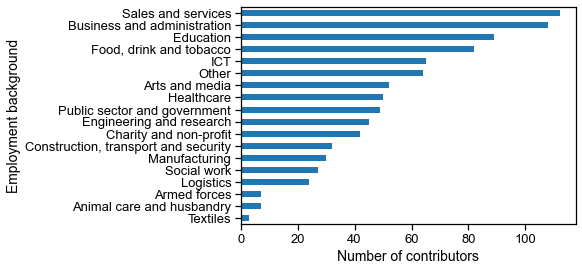

In [18]:
background_df.sum().sort_values().plot.barh()
plt.xlabel('Number of contributors')
plt.ylabel('Employment background');
plotting_utils.export_figure('contributors_Backgrounds', figure_folder=figure_folder, png=True, svg=True)

## 1.1 Contributor activity

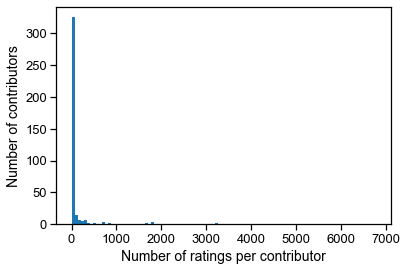

In [19]:
# Number of assessments by a coder
coder_counts = batch_results.groupby('coder_id').agg({'classification_id': 'count'})
fig, ax = plt.subplots()
ax.hist(coder_counts['classification_id'], bins=100)
ax.set_xlabel('Number of ratings per contributor')
ax.set_ylabel('Number of contributors');
plotting_utils.export_figure('contributors_Activity', figure_folder=figure_folder, png=True, svg=True)
plt.show()

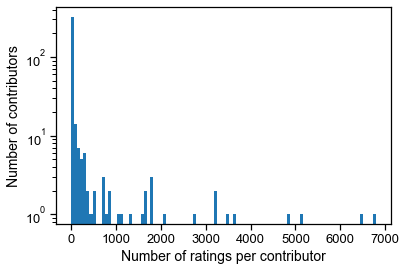

In [20]:
# Logarithmic plot
fig, ax = plt.subplots()
ax.hist(coder_counts['classification_id'], bins=100)
ax.set_xlabel('Number of ratings per contributor')
ax.set_ylabel('Number of contributors');
ax.set_yscale('log')
plotting_utils.export_figure('contributors_Activity_Log', figure_folder=figure_folder, png=True, svg=True)

Note the fat tail of the distribution - we should be aware of the outsized influence of a minority of active contributors.

In [21]:
# Median number of contributions
coder_counts['classification_id'].median()

3.0

Only 30% of coders made more than 10 contributions, while 50% made 3 or less.

In [22]:
# Number of contributors with 1 contribution
(coder_counts['classification_id']==1).sum()/N

0.3178294573643411

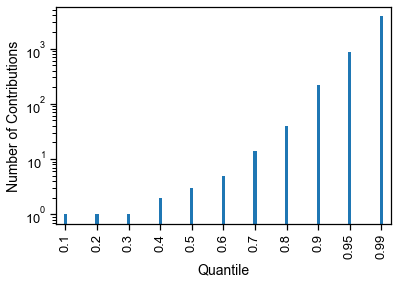

In [23]:
fig, ax = plt.subplots()
(coder_counts
 .quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99])
 .plot.bar(width=0.1, legend=None, ax=ax))
ax.set_yscale('log')
ax.set_xlabel('Quantile')
ax.set_ylabel('Number of Contributions');

In [24]:
# 90th percentile of contributions per coder
np.percentile(coder_counts.classification_id, 90)

216.4000000000002

In [25]:
# What percentile is 100 contributions per coder
percentileofscore(coder_counts.classification_id, 100)

85.27131782945736

In [26]:
# Number of coders with 100 or more contributions
(coder_counts.classification_id >= 100).sum()

57

In [27]:
# Maximal number of contributions
coder_counts.classification_id.max()

6786

# 2. Coverage of transitions

See if all of the transitions provided by us have been tested by the validators

In [28]:
# Check that the # of transitions match
assert(len(batch) == len(batch_results.subject_ids.unique()))

In [29]:
# Check if any transitions are missing
df = batch.merge(batch_results[['origin_id', 'destination_id', 'subject_ids']],
                 on=['origin_id', 'destination_id'])
df[df.subject_ids.isnull()]

,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,unmatched_skills,subject_ids


In [30]:
# Number of ratings per transition
transition_counts = batch_results.groupby('subject_ids').count()


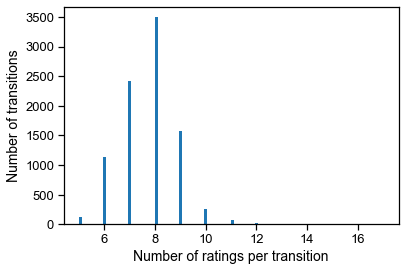

In [31]:
# Distribution of the number of ratings per transition
fig, ax = plt.subplots()
ax.hist(transition_counts['classification_id'], bins=100)
ax.set_xlabel('Number of ratings per transition')
ax.set_ylabel('Number of transitions');
plotting_utils.export_figure('transitions_Ratings', figure_folder=figure_folder, png=True, svg=True)

In [32]:
# Smallest number of ratings
transition_counts.classification_id.min()

5

In [33]:
# Largest number of ratings
transition_counts.classification_id.max()

17

In [34]:
# Average number of ratings
transition_counts.classification_id.mean()

7.720728629430484

# 3. Crowdsourced familiarity and feasibility ratings

In [35]:
batch_results.head()

,classification_id,subject_ids,origin_id,origin_label,origin_description,destination_id,destination_label,destination_description,perfectly_matched_skills,partially_matched_skills,...,familiarity_with_destination_1-5,feasibility_1-5,Reasons,coder_id,questionable_respondant_flag,gender,background,highest_qualification,time_stamp,age_group
0,289643147,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,2,3,**Qualifications** - different qualification r...,566802cf6d9c32c4b9d6,False,Male,"['Education','Healthcare']",Master'degree,NaN,20-29
1,289715915,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,3,3,"**Skills** - poor skills overlap, missing esse...",dfaa44417fdef5173766,False,Female,"['Healthcare', 'Sales and services']",Bachelor's degree,NaN,50-59
2,289776880,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,1,2,"**Skills** - poor skills overlap, missing esse...",b929c3beb0e7ffb1ea4a,False,Male,"['Education','Engineering and research']",Doctorate,NaN,30-39
3,289806895,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,4,1,**Qualifications** - different qualification r...,20df3373ab16becb8f2e,False,Male,['Sales and services'],GCSE,NaN,30-39
4,290219173,52451278,29,legal guardian,Legal guardians legally assist and support min...,2654,employment and vocational integration consultant,Employment and vocational integration consulta...,give advice on personal matters; listen actively,facilitate job market access; develop course o...,...,2,2,**Qualifications** - different qualification r...,ef345455b53500fbb303,False,Female,"['Business and administration', 'Public sector...",Bachelor's degree,NaN,30-39


In [36]:
# Total number of ratings
len(batch_results)

70359

In [37]:
# Total number of assessed transitions 
len(batch_results.subject_ids.unique())

9113

In [38]:
# Total number of unique occupations included in the study
len(set(batch_results.origin_id.unique()).union(set(batch_results.destination_id.unique())))

1571

In [39]:
# Total number of unique contributors
len(batch_results.coder_id.unique())

387

## 3.1 Familiarity ratings

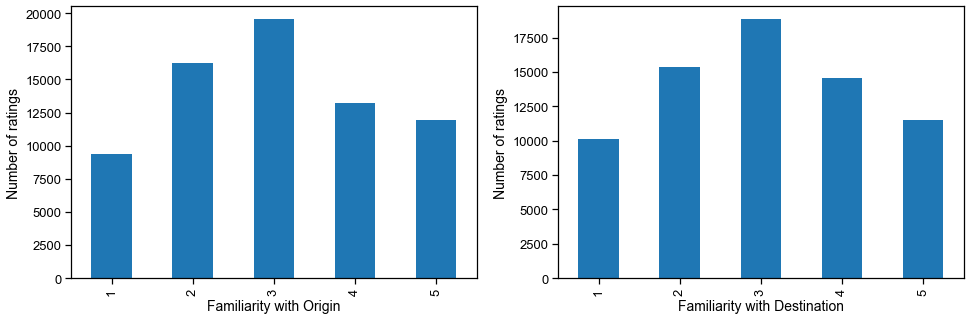

In [40]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 5))

batch_results.groupby('familiarity_with_origin_1-5').agg({'classification_id': 'count'}).plot.bar(ax=axs[0], legend=None)
axs[0].set_xlabel('Familiarity with Origin')
axs[0].set_ylabel('Number of ratings')
batch_results.groupby('familiarity_with_destination_1-5').agg({'classification_id': 'count'}).plot.bar(ax=axs[1], legend=None)
axs[1].set_xlabel('Familiarity with Destination')
axs[1].set_ylabel('Number of ratings');

plotting_utils.export_figure('ratings_Familiarity', figure_folder=figure_folder, png=True, svg=True)

The distribution of familiarity for both the origin and destination jobs.

In [41]:
batch_results['familiarity_with_origin_1-5'].mean().round(2)

3.03

In [42]:
batch_results['familiarity_with_destination_1-5'].mean().round(2)

3.03

### Least and most familiar occupations

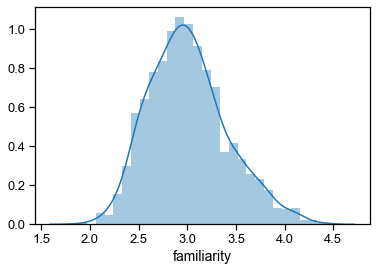

In [43]:
# Distribution of mean familiarity scores across occupations
occupation_familiarity_all = pd.DataFrame(data={
    'id': batch_results['origin_id'].to_list() + batch_results['destination_id'].to_list(),
    'label': batch_results['origin_label'].to_list() + batch_results['destination_label'].to_list(),    
    'familiarity': batch_results['familiarity_with_origin_1-5'].to_list() + batch_results['familiarity_with_destination_1-5'].to_list(),
})

occupation_familiarity = occupation_familiarity_all.groupby('id').agg({'familiarity': 'mean'}).reset_index()
occupation_familiarity = occupation_familiarity.merge(occupation_familiarity_all.drop_duplicates('id')[['id', 'label']], how='left')
sns.distplot(occupation_familiarity.familiarity)
plt.show()

In [44]:
# Least familiar occupations
occupation_familiarity.sort_values('familiarity').head(15)

,id,familiarity,label
1525,2848,1.875000,mine safety officer
927,1720,2.058824,electrolytic cell maker
214,396,2.062500,on foot aquatic resources collector
1228,2270,2.068966,nitroglycerin neutraliser
12,24,2.071429,dismantling engineer
223,410,2.117647,gauger
525,996,2.125000,irrigation technician
1353,2497,2.125000,aquaculture mooring manager
560,1066,2.142857,firework assembler
181,326,2.200000,water treatment systems operator


In [45]:
# Most familiar occupations
occupation_familiarity.sort_values('familiarity').tail(15)

,id,familiarity,label
929,1724,4.100000,cook
1472,2726,4.114286,general veterinarian
603,1134,4.123596,secondary school teacher
65,120,4.129032,hairdresser
1002,1856,4.142857,fashion model
1437,2662,4.142857,extra
583,1104,4.142857,member of parliament
1423,2634,4.153846,kitchen assistant
939,1739,4.166667,window cleaner
1344,2481,4.173913,shelf filler


### Differences in familiarity between origin and destination occupations

In [46]:
batch_results['familiarity_diff'] = (batch_results['familiarity_with_origin_1-5']
                                     - batch_results['familiarity_with_destination_1-5'])
batch_results['familiarity_total'] = (batch_results['familiarity_with_origin_1-5']
                                     + batch_results['familiarity_with_destination_1-5'])

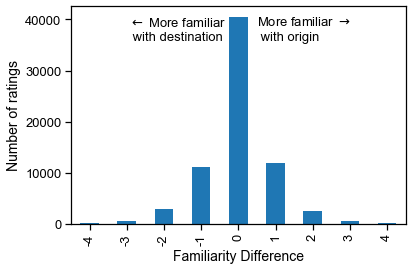

In [47]:
fig, ax = plt.subplots()

(batch_results['familiarity_diff']
 .value_counts().sort_index()
 .plot.bar(ax=ax))

ax.text(1.05, 36000, '$\leftarrow$ More familiar \n with destination')
ax.text(4.5, 36000, 'More familiar ' + r'$\rightarrow$'+ '\n with origin')
ax.set_xlabel('Familiarity Difference')
ax.set_ylabel('Number of ratings');
plotting_utils.export_figure('ratings_Familiarity_difference', figure_folder=figure_folder, png=True, svg=True)

In [48]:
# More familiar with the origin
batch_results.sort_values('familiarity_diff')[['origin_label', 'destination_label', 'familiarity_diff']].tail(10)

,origin_label,destination_label,familiarity_diff
64677,midwife,respiratory therapy technician,4
19913,webmaster,knowledge engineer,4
62035,plastic rolling machine operator,mechanical forging press worker,4
67366,pharmacist,physiotherapy assistant,4
40136,construction commercial diver,director of compliance and information securit...,4
19904,webmaster,ICT intelligent systems designer,4
14122,social care worker,sales account manager,4
6090,food analyst,gauger,4
3698,travel consultant,purchaser,4
30756,bank manager,business developer,4


In [49]:
# More familiar with the destination occupation
batch_results.sort_values('familiarity_diff')[['origin_label', 'destination_label', 'familiarity_diff']].head(10)

,origin_label,destination_label,familiarity_diff
39660,lime kiln operator,speech and language therapist,-4
42629,motorcycle assembler,airport baggage handler,-4
49532,pasta operator,edge bander operator,-4
60045,straightening machine operator,electroplating machine operator,-4
40528,metal products assembler,postman/postwoman,-4
57407,mechanical forging press worker,blow moulding machine operator,-4
45481,dairy products manufacturing worker,factory hand,-4
44238,underwater construction supervisor,railway station manager,-4
193,tour operators manager,brand manager,-4
39287,oxy fuel burning machine operator,leaflet distributor,-4


## 3.2 Feasibility ratings

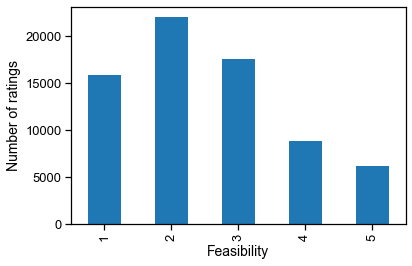

In [50]:
# Distribution of feasibility ratings
fig, ax = plt.subplots()

batch_results.groupby('feasibility_1-5').agg({'classification_id': 'count'}).plot.bar(ax=ax, legend=None)
ax.set_xlabel('Feasibility')
ax.set_ylabel('Number of ratings')
plotting_utils.export_figure('ratings_Feasibility_distribution', figure_folder=figure_folder, png=True, svg=True)

In [51]:
batch_results['feasibility_1-5'].mean().round(2)

2.54

The distribution of feasibility ratings appears to follow a skewed normal distribution.

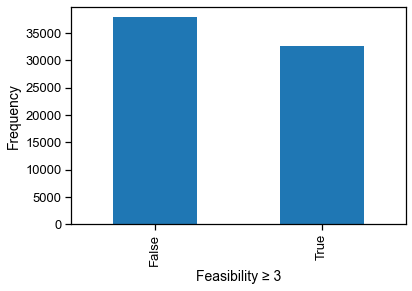

In [52]:
fig, ax = plt.subplots()

(batch_results['feasibility_1-5'] > 2).value_counts().plot.bar()
ax.set_xlabel('Feasibility ≥ 3')
ax.set_ylabel('Frequency');

In [53]:
# Fraction of 'feasible' ratings across all data
np.sum(batch_results['feasibility_1-5'] > 2) / len(batch_results)

0.46211572080330876

### Aggregate mean feasibility and above-threshold ratings across occupations

In [54]:
# Boolean flags for ratings above a certain threshold
batch_results['is_gt_2'] = batch_results['feasibility_1-5'] > 2
batch_results['is_gt_3'] = batch_results['feasibility_1-5'] > 3
batch_results['is_gt_4'] = batch_results['feasibility_1-5'] > 4

In [55]:
# Aggregate
transition_mean = (batch_results
 .groupby(['origin_label', 'destination_label'])
 [['feasibility_1-5', 'familiarity_with_origin_1-5', 
   'familiarity_with_destination_1-5', 'familiarity_diff',
   'familiarity_total', 'is_gt_2', 'is_gt_3', 'is_gt_4' 
  ]]
 .mean())

transition_std = (batch_results
 .groupby(['origin_label', 'destination_label'])
 [['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5', 'familiarity_diff']]
 .std())

In [56]:
# Least feasible transitions
transition_mean.reset_index().sort_values('feasibility_1-5').head(10)

,origin_label,destination_label,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5,familiarity_diff,familiarity_total,is_gt_2,is_gt_3,is_gt_4
5103,lime kiln operator,speech and language therapist,1.0,1.750000,3.125000,-1.375000,4.875000,0.0,0.0,0.0
5069,legal guardian,recreational therapist,1.0,3.714286,3.285714,0.428571,7.000000,0.0,0.0,0.0
572,advanced physiotherapist,tax compliance officer,1.0,3.000000,2.888889,0.111111,5.888889,0.0,0.0,0.0
8897,weaving machine operator,astronomer,1.0,3.000000,4.142857,-1.142857,7.142857,0.0,0.0,0.0
2229,composer,lexicographer,1.0,3.125000,2.375000,0.750000,5.500000,0.0,0.0,0.0
8743,vehicle rental agent,geographic information systems specialist,1.0,3.375000,3.250000,0.125000,6.625000,0.0,0.0,0.0
8694,user interface developer,architect,1.0,2.666667,3.500000,-0.833333,6.166667,0.0,0.0,0.0
6402,podiatrist,aircraft marshaller,1.0,2.666667,2.333333,0.333333,5.000000,0.0,0.0,0.0
2216,community health worker,interpreter,1.0,3.125000,3.375000,-0.250000,6.500000,0.0,0.0,0.0
4194,glass polisher,mediator,1.0,2.444444,2.333333,0.111111,4.777778,0.0,0.0,0.0


In [57]:
# Most feasible transitions
transition_mean.reset_index().sort_values('feasibility_1-5').tail(10)

,origin_label,destination_label,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5,familiarity_diff,familiarity_total,is_gt_2,is_gt_3,is_gt_4
9017,welder,metal rolling mill operator,4.571429,3.714286,2.714286,1.000000,6.428571,1.0,1.000000,0.571429
8257,textile product developer,textile printer,4.571429,2.857143,2.857143,0.000000,5.714286,1.0,0.857143,0.714286
5738,motorcycle delivery person,postman/postwoman,4.625000,3.750000,4.125000,-0.375000,7.875000,1.0,1.000000,0.625000
2785,data entry clerk,data entry supervisor,4.625000,3.125000,3.250000,-0.125000,6.375000,1.0,0.875000,0.750000
7437,shop assistant,bartender,4.625000,4.625000,4.500000,0.125000,9.125000,1.0,1.000000,0.625000
1188,bindery operator,paperboard products assembler,4.666667,3.000000,2.666667,0.333333,5.666667,1.0,1.000000,0.666667
743,animal handler,animal care attendant,4.666667,3.500000,3.500000,0.000000,7.000000,1.0,1.000000,0.666667
4389,hotel butler,steward/stewardess,4.714286,3.714286,3.714286,0.000000,7.428571,1.0,1.000000,0.714286
4911,kitchen porter,kitchen assistant,4.714286,3.714286,4.000000,-0.285714,7.714286,1.0,0.857143,0.857143
4451,human resources officer,human resources manager,4.833333,3.500000,3.666667,-0.166667,7.166667,1.0,1.000000,0.833333


## 3.3 Relationship between feasibility and familiarity

### Pearson correlations

In [58]:
feasibility_familiarity = batch_results[
    ['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5']].corr(method='pearson')

feasibility_familiarity

,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5
feasibility_1-5,1.000000,0.225720,0.221305
familiarity_with_origin_1-5,0.225720,1.000000,0.750772
familiarity_with_destination_1-5,0.221305,0.750772,1.000000


In [59]:
print(pearsonr(batch_results['feasibility_1-5'], batch_results['familiarity_with_origin_1-5']))
print(pearsonr(batch_results['feasibility_1-5'], batch_results['familiarity_with_destination_1-5']))
print(pearsonr(batch_results['familiarity_with_origin_1-5'], batch_results['familiarity_with_destination_1-5']))

(0.22571961367497356, 0.0)
(0.22130467777582596, 0.0)
(0.7507717307746727, 0.0)


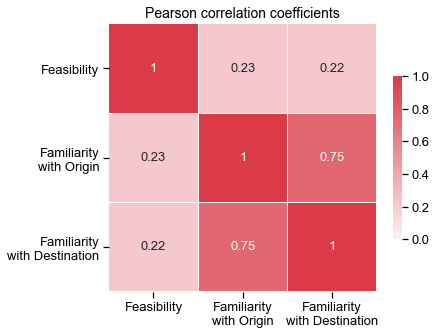

In [60]:
plotting_utils.plot_heatmap(feasibility_familiarity.to_numpy(),
                            x_labels = ['Feasibility', 'Familiarity\nwith Origin', 'Familiarity\nwith Destination'],
                            shorten_xlabel=False, figsize=(6,6), limits=(0,1))
plt.xticks(rotation=0)
plt.title('Pearson correlation coefficients')

plotting_utils.export_figure('corr_Feasibility_Familiarity_Pearson', figure_folder=figure_folder, png=True, svg=True)

### Spearman correlations

In [61]:
feasibility_familiarity = batch_results[
    ['feasibility_1-5', 'familiarity_with_origin_1-5', 'familiarity_with_destination_1-5']].corr(method='spearman')

feasibility_familiarity

,feasibility_1-5,familiarity_with_origin_1-5,familiarity_with_destination_1-5
feasibility_1-5,1.000000,0.196113,0.190401
familiarity_with_origin_1-5,0.196113,1.000000,0.743249
familiarity_with_destination_1-5,0.190401,0.743249,1.000000


In [62]:
print(spearmanr(batch_results['feasibility_1-5'], batch_results['familiarity_with_origin_1-5']))
print(spearmanr(batch_results['feasibility_1-5'], batch_results['familiarity_with_destination_1-5']))
print(spearmanr(batch_results['familiarity_with_origin_1-5'], batch_results['familiarity_with_destination_1-5']))

SpearmanrResult(correlation=0.19611272998600898, pvalue=0.0)
SpearmanrResult(correlation=0.1904010488260159, pvalue=0.0)
SpearmanrResult(correlation=0.7432487433995777, pvalue=0.0)


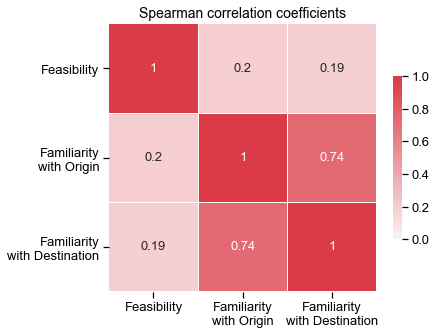

In [63]:
plotting_utils.plot_heatmap(feasibility_familiarity.to_numpy(),
                            x_labels = ['Feasibility', 'Familiarity\nwith Origin', 'Familiarity\nwith Destination'],
                            shorten_xlabel=False, figsize=(6,6), limits=(0,1))
plt.xticks(rotation=0)
plt.title('Spearman correlation coefficients')

plotting_utils.export_figure('corr_Feasibility_Familiarity_Spearman', figure_folder=figure_folder, png=True, svg=True)

The familiarity with the origin and destination occupations are correlated showing that coders generally had a similar level of familiartiy with both occupations when judging a transition. Familiarity does not seem to correlate strongly with the feasibility rating.

### Correlation between transitions' mean familiarity and mean feasibility

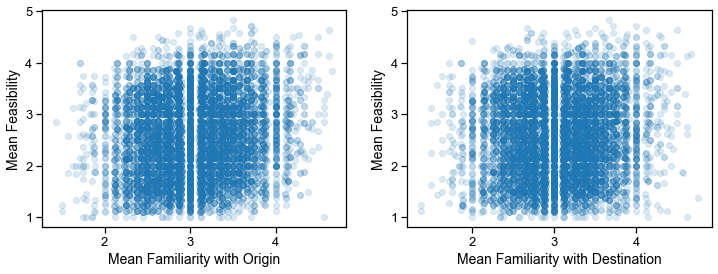

In [64]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(transition_mean['familiarity_with_origin_1-5'], transition_mean['feasibility_1-5'], alpha=0.15)
axs[0].set_xlabel('Mean Familiarity with Origin')
axs[0].set_ylabel('Mean Feasibility')

axs[1].scatter(transition_mean['familiarity_with_destination_1-5'], transition_mean['feasibility_1-5'], alpha=0.15)
axs[1].set_xlabel('Mean Familiarity with Destination')
axs[1].set_ylabel('Mean Feasibility');

plotting_utils.export_figure('Mean_Feasibility_Familiarity', figure_folder=figure_folder, png=True, svg=True)


In [65]:
print(spearmanr(transition_mean['feasibility_1-5'], transition_mean['familiarity_with_origin_1-5']))
print(spearmanr(transition_mean['feasibility_1-5'], transition_mean['familiarity_with_destination_1-5']))
print(spearmanr(transition_mean['familiarity_with_origin_1-5'], transition_mean['familiarity_with_destination_1-5']))

SpearmanrResult(correlation=0.12029385142760464, pvalue=1.0011183944287439e-30)
SpearmanrResult(correlation=0.047472022802234226, pvalue=5.795653048332515e-06)
SpearmanrResult(correlation=0.5925154155903014, pvalue=0.0)


### Correlation between transitions' mean familiarity and variation across feasibility ratings

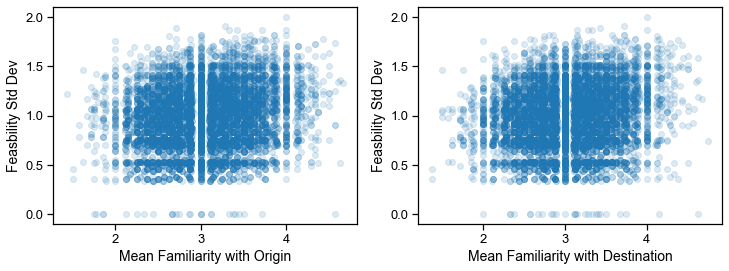

In [66]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(transition_mean['familiarity_with_origin_1-5'], transition_std['feasibility_1-5'], alpha=0.15)
axs[0].set_xlabel('Mean Familiarity with Origin')
axs[0].set_ylabel('Feasbility Std Dev')

axs[1].scatter(transition_mean['familiarity_with_destination_1-5'], transition_std['feasibility_1-5'], alpha=0.15)
axs[1].set_xlabel('Mean Familiarity with Destination')
axs[1].set_ylabel('Feasbility Std Dev');


In [67]:
print(spearmanr(transition_std['feasibility_1-5'], transition_mean['familiarity_with_origin_1-5']))
print(spearmanr(transition_std['feasibility_1-5'], transition_mean['familiarity_with_destination_1-5']))

SpearmanrResult(correlation=0.14987661207461192, pvalue=6.254276633341883e-47)
SpearmanrResult(correlation=0.11748257609852011, pvalue=2.249341975764867e-29)


In [68]:
# Most contentious transitions
transition_std.sort_values('feasibility_1-5', ascending=False).head(20)['feasibility_1-5']

origin_label                            destination_label             
sales assistant                         locker room attendant             2.000000
maternity support worker                radiographer                      1.902379
orthoptist                              occupational therapist            1.889822
physiotherapist                         podiatrist                        1.864454
funeral services director               funeral attendant                 1.864454
hospitality establishment receptionist  post office counter clerk         1.861899
academic support officer                higher education lecturer         1.861899
credit adviser                          economic policy officer           1.816590
tutor                                   circus arts teacher               1.812654
drafter                                 printed circuit board designer    1.812654
secondary school teaching assistant     lifeguard instructor              1.812654
advanced physiot

### Cluster analysis [in progress]

In [69]:
results_breakdown = (batch_results
                     .groupby(['origin_label', 'destination_label', 'feasibility_1-5'])['classification_id']
                     .count()
                     .unstack()
                     .fillna(0))
results_breakdown_norm = results_breakdown.div(results_breakdown.sum(axis=1), axis=0)

In [70]:
results_breakdown_norm_ = results_breakdown_norm.sample(200, random_state=0)

dists = pd.DataFrame(
    1 - pairwise_distances(results_breakdown_norm_, metric='euclidean'),
    index=results_breakdown_norm_.index,
    columns=results_breakdown_norm_.index
)

/Users/karliskanders/opt/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/seaborn/matrix.py:649: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



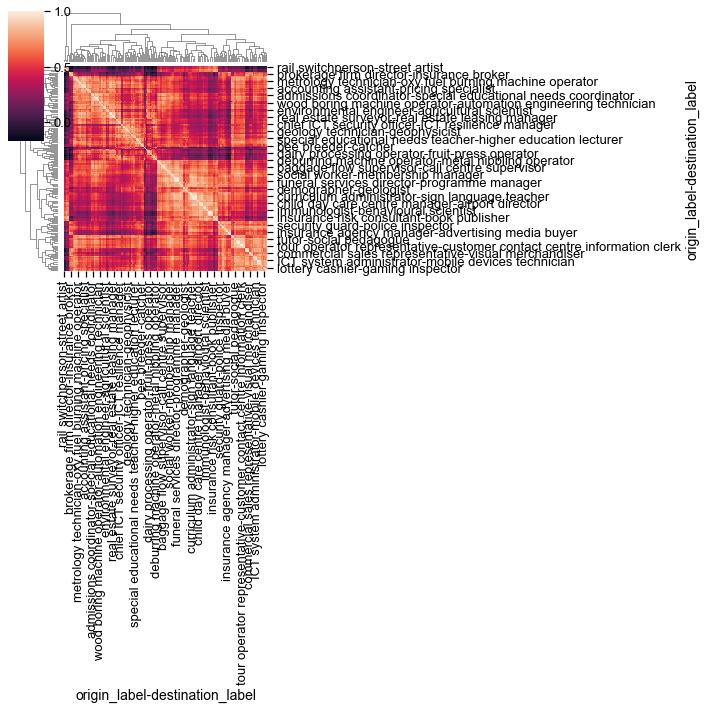

In [71]:
sns.clustermap(dists)

Open questions:
- Clusters off the diagonal could indicate areas of disagreement.
- Going forward, we might want to threshold the level of uncertainty.
- Do people who give different results also cite different reasons?

### Mean feasibility vs. proportion of ratings above a certain threshold

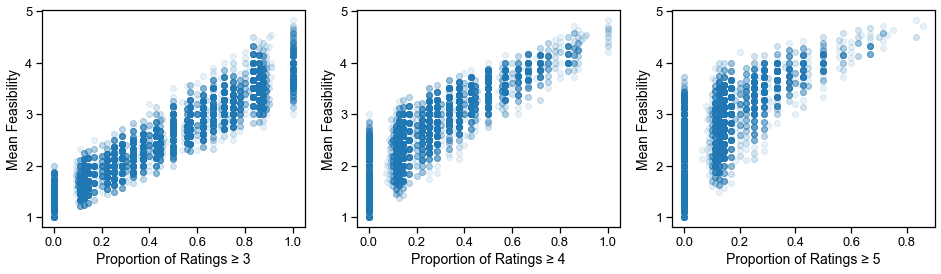

In [72]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 4))

for i, col in enumerate(['is_gt_2', 'is_gt_3', 'is_gt_4']):
    axs[i].scatter(transition_mean[col], transition_mean['feasibility_1-5'], alpha=0.1)
    axs[i].set_xlabel(f'Proportion of Ratings ≥ {int(col.split("_")[-1]) + 1}')
    axs[i].set_ylabel('Mean Feasibility')
    
plotting_utils.export_figure('Mean_Feasibility_Proportion_ratings', figure_folder=figure_folder, png=True, svg=True)    

In [73]:
# Fraction of transitions that have mean feasibility below 3, but more than 20% of ratings are above 2
df = transition_mean.reset_index()
df = df[df['feasibility_1-5']<3]
(df.is_gt_2 > 0.2).sum() / len(df)

0.6658940397350993

In [74]:
# Fraction of transitions that have mean feasibility below 3, but more than 40% of ratings are above 2
(df.is_gt_2 > 0.4).sum() / len(df)

0.3379139072847682

### Export the mean feasibility and familarity ratings

In [75]:
data = load_data.Data()
transition_mean_df = (batch_results
 .groupby(['origin_id', 'destination_id'])
 [['feasibility_1-5', 'is_gt_2']]
 .mean()).rename(columns={'feasibility_1-5':'feasibility'})
transition_mean_df = data.add_field_to_occupation(transition_mean_df.reset_index(), 'origin_id', 'preferred_label').rename(columns={'preferred_label':'origin_label'})
transition_mean_df = data.add_field_to_occupation(transition_mean_df, 'destination_id', 'preferred_label').rename(columns={'preferred_label':'destination_label'})
transition_mean_df = transition_mean_df[['origin_id','origin_label','destination_id', 'destination_label', 'feasibility', 'is_gt_2']]

# Export the mean ratings for each transition
transition_mean_df.to_csv(useful_paths.data_dir+'processed/validation/crowd_feasibility_ratings_mean.csv', index=False)


## 3.4 Exploring reasons for ratings

In [76]:
batch_results['reasons'] = batch_results['Reasons'].str.extract(r'.*?\*\*(.*)\*\*.*')
batch_results['reasons'] = batch_results['reasons'].str.lower().str.replace(' ', '_')
batch_results = batch_results.drop('Reasons', axis=1)

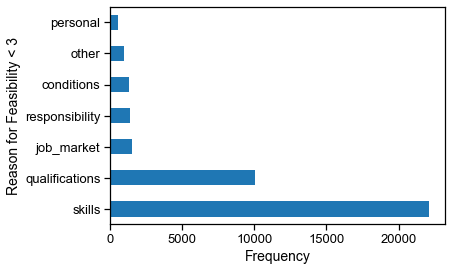

In [77]:
fig, ax = plt.subplots()
batch_results[batch_results['feasibility_1-5'] < 3]['reasons'].value_counts().plot.barh(ax=ax)
ax.set_xlabel('Frequency')
ax.set_ylabel('Reason for Feasibility < 3');

In [78]:
transition_reasons = (batch_results.groupby(['origin_label', 'destination_label'])['reasons']
                      .apply(lambda x: ' '.join(list(x))))

cv = CountVectorizer()
cv.fit(transition_reasons)
reason_counts = pd.DataFrame(cv.transform(transition_reasons).todense(), columns=cv.get_feature_names())
reason_share = reason_counts.divide(reason_counts.sum(axis=1), axis=0)

reason_share.index = transition_reasons.index

In [79]:
reason_share = reason_share.join(
    batch_results
    .groupby(['origin_label', 'destination_label'])
    ['feasibility_1-5'].mean()
)

In [80]:
# Examples of reasons for rejecting transitions (feasibility less or equal to 2)
for skill in batch_results['reasons'].value_counts().index:
    df = reason_share[reason_share['feasibility_1-5'] <= 2]
    df['inv_f'] = 5 - df['feasibility_1-5']
    df = df.sort_values([skill, 'inv_f'], ascending=False).head(10)
    print(skill.replace('_', ' ').title())
    [print('-', ' ==> '.join(_)) for _ in df.index.to_list()]
    print('')

Skills
- economic policy officer ==> fisheries master
- rigger ==> cosmetics production machine operator
- textile product developer ==> promoter
- ATM repair technician ==> stringed musical instrument maker
- hand brick moulder ==> auctioneer
- security guard ==> sauce production operator
- urban planner ==> bee breeder
- poultry sexer ==> product assembly inspector
- fisheries assistant engineer ==> movie distributor
- surface miner ==> proofreader

Qualifications
- user interface developer ==> architect
- relocation officer ==> lawyer
- food analyst ==> materials engineer
- insurance risk consultant ==> meteorologist
- orthoptist ==> pharmacist
- pipeline route manager ==> materials engineer
- orthoptist ==> specialist chiropractor
- corporate training manager ==> secondary school teacher
- optometrist ==> podiatrist
- optometrist ==> speech and language therapist

Other
- animation layout artist ==> dramaturge
- insurance agency manager ==> provincial governor
- actuarial consultan

/Users/karliskanders/opt/miniconda3/envs/mapping_career_causeways/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# 4. Correspondence between feasibility and occupation similarity measures

In [81]:
def get_similarities(df, W, col_name = 'similarity'):
    """ Find similarity values in matrix W, for transitions specified in dataframe df """
    sim_list = []
    for j, row in df.iterrows():
        sim = W[int(row.origin_id), int(row.destination_id)]
        sim_list.append(sim)
    df[col_name] = sim_list 
    return df


In [82]:
# Check the mean feasibility for each transition
batch_results_agg = (batch_results
                     .groupby('subject_ids')
                     .agg({'feasibility_1-5': 'mean'})
                     .reset_index())

# Add occupation IDs 
batch_results_agg = batch_results_agg.merge(batch_results.drop_duplicates('subject_ids')[[
    'origin_id', 'destination_id',
    'origin_label', 'destination_label',
    'subject_ids']], on=['subject_ids'], how='left')

batch_results_agg.sample(5)

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label
8979,53142569,3.666667,1957,1971,metal planer operator,straightening machine operator
4884,53137846,1.333333,1908,876,insurance broker,surface miner
2043,52686052,1.333333,1907,203,corporate training manager,ICT disaster recovery analyst
8948,53142538,3.666667,1749,1901,drop forging hammer worker,extrusion machine operator
87,52451454,1.444444,89,2120,recruitment consultant,railway station manager


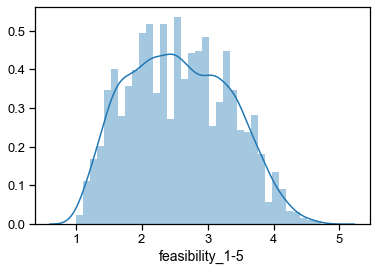

In [83]:
sns.distplot(batch_results_agg['feasibility_1-5'])
plt.show()

In [84]:
# Add similarity values to the table
df = get_similarities(batch_results_agg, sims.W_combined, col_name = 'similarity_combined')
df = get_similarities(df, sims.W_essential, col_name = 'similarity_essential_skills')
df = get_similarities(df, sims.W_all_to_essential, col_name = 'similarity_optional_skills')
df = get_similarities(df, sims.W_activities, col_name = 'similarity_activities')
df = get_similarities(df, sims.W_work_context, col_name = 'similarity_work_context')

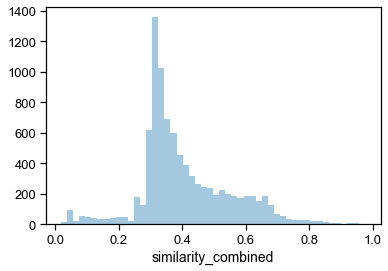

In [85]:
sns.distplot(df.similarity_combined, kde=False)
plt.show()

### Combined similarity measure

In [86]:
def plot_scatter(df=df, x='similarity', y='feasibility_1-5'):
    plt.scatter(
        x=df[x],
        y=df[y],
        alpha=0.15)
    plt.xlabel(x)
    plt.ylabel('Mean Feasibility')
    plt.xlabel(x)    
    print(f'Pearson correlation: {pearsonr(df[x], df[y])}')
    print(f'Spearman correlation: {spearmanr(df[x], df[y])}')

Pearson correlation: (0.6964873742301811, 0.0)
Spearman correlation: SpearmanrResult(correlation=0.7063937609987885, pvalue=0.0)


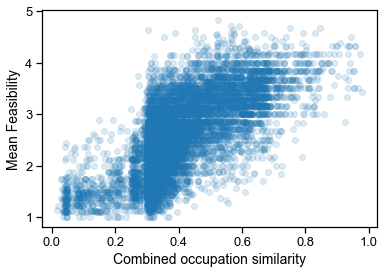

In [87]:
plot_scatter(x='similarity_combined', y='feasibility_1-5')
plt.xlabel('Combined occupation similarity')
plotting_utils.export_figure('corr_Feasibility_vs_Combined_similarity', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### Essential skills similarity measure

Pearson correlation: (0.6764875698562529, 0.0)
Spearman correlation: SpearmanrResult(correlation=0.6992837855685615, pvalue=0.0)


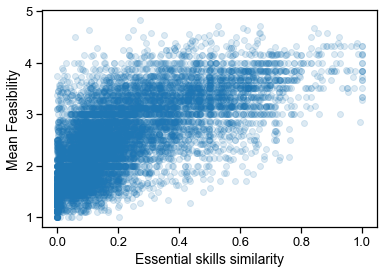

In [90]:
x='similarity_essential_skills'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Essential skills similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### Optional skills similarity measure

Note: Optional skills similarity measures the similarity between all ('essential' and 'optional') skills at the origin occupation, and the 'essential' skills at the destination occupation.

Pearson correlation: (0.7578059352967147, 0.0)
Spearman correlation: SpearmanrResult(correlation=0.7734076215956829, pvalue=0.0)


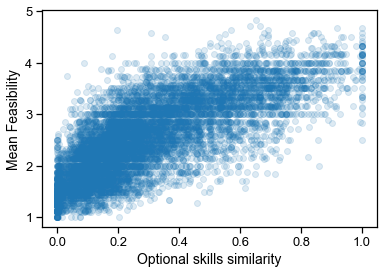

In [91]:
x='similarity_optional_skills'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Optional skills similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### Work activity similarity measure

Pearson correlation: (0.3304338086140815, 4.533049060830223e-231)
Spearman correlation: SpearmanrResult(correlation=0.3029453013080132, pvalue=9.743575640118783e-193)


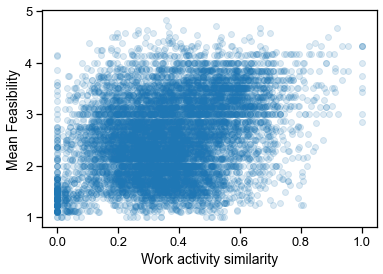

In [92]:
x='similarity_activities'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Work activity similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

### Work context similarity measure

Pearson correlation: (0.24324393753240436, 7.420690962834337e-123)
Spearman correlation: SpearmanrResult(correlation=0.14423999270165022, pvalue=1.4624209910547692e-43)


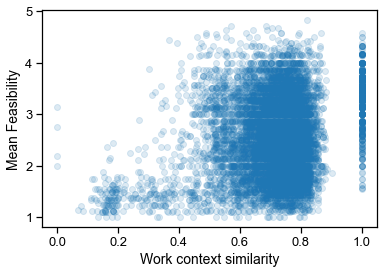

In [93]:
x='similarity_work_context'
plot_scatter(x=x, y='feasibility_1-5')
plt.xlabel('Work context similarity') 
plotting_utils.export_figure(f'corr_Feasibility_vs_{x}', figure_folder=figure_folder, png=True, svg=True)
plt.show()

## Robustness tests w.r.t active contributors

In [94]:
sorted_coders = coder_counts.sort_values('classification_id', ascending=False)

In [95]:
# Fraction of contributions made by the top-8 most active contributors
sorted_coders.head(8).sum() / len(batch_results)

classification_id    0.523472
dtype: float64

In [96]:
sorted_coders.head(8)

,classification_id
coder_id,
a33630934d5122edc8cb,6786
b929c3beb0e7ffb1ea4a,6451
30b1fb752d7b16f8968d,5156
566802cf6d9c32c4b9d6,4826
f989db16c0d3fca1f960,3660
32f99cea1d9ea469bdfe,3516
9fa97ce4c309a3033415,3239
6d45a1651ba5423e7762,3197


In [97]:
# Super-coders list
super_coders = sorted_coders.head(8).index.to_list()
super_coders

['a33630934d5122edc8cb',
 'b929c3beb0e7ffb1ea4a',
 '30b1fb752d7b16f8968d',
 '566802cf6d9c32c4b9d6',
 'f989db16c0d3fca1f960',
 '32f99cea1d9ea469bdfe',
 '9fa97ce4c309a3033415',
 '6d45a1651ba5423e7762']

In [98]:
df.head()

,subject_ids,feasibility_1-5,origin_id,destination_id,origin_label,destination_label,similarity_combined,similarity_essential_skills,similarity_optional_skills,similarity_activities,similarity_work_context
0,52451278,2.000000,29,2654,legal guardian,employment and vocational integration consultant,0.333975,0.117440,0.119270,0.374365,0.724825
1,52451279,2.888889,29,1803,legal guardian,special educational needs teacher,0.319810,0.019986,0.245352,0.305689,0.708213
2,52451280,2.875000,29,1036,legal guardian,social counsellor,0.364106,0.073114,0.073994,0.513570,0.795748
3,52451281,3.857143,29,2877,legal guardian,social pedagogue,0.352374,0.086090,0.165216,0.374458,0.783730
4,52451282,2.222222,29,2292,legal guardian,social services manager,0.316622,0.068399,0.069652,0.417696,0.710741


In [99]:
pearsonr(df['feasibility_1-5'], df['similarity_combined'])[0]

0.6964873742301811

In [100]:
similarity_columns = [
    'similarity_combined', 
    'similarity_essential_skills', 
    'similarity_optional_skills',
    'similarity_activities',
    'similarity_work_context']
    
def get_robustness_results(n):
    batch_results_removed = batch_results[-batch_results.coder_id.isin(super_coders[0:n])]

    batch_results_agg = (batch_results_removed
                         .groupby('subject_ids')
                         .agg({'feasibility_1-5': 'mean'})
                         .reset_index())
    
    # Add occupation IDs 
    batch_results_agg = batch_results_agg.merge(batch_results_removed.drop_duplicates('subject_ids')[[
        'origin_id', 'destination_id',
        'origin_label', 'destination_label',
        'subject_ids']], on=['subject_ids'], how='left')

    # Add similarity values to the table
    df = get_similarities(batch_results_agg, sims.W_combined, col_name = 'similarity_combined')
    df = get_similarities(df, sims.W_essential, col_name = 'similarity_essential_skills')
    df = get_similarities(df, sims.W_all_to_essential, col_name = 'similarity_optional_skills')
    df = get_similarities(df, sims.W_activities, col_name = 'similarity_activities')
    df = get_similarities(df, sims.W_work_context, col_name = 'similarity_work_context')

    corr_coeffs = {}
    for x in similarity_columns: 
        corr_coeff, pvalue = spearmanr(df[x], df['feasibility_1-5'])
        corr_coeffs[x] = corr_coeff
        corr_coeffs[x+'_p'] = pvalue
    
    corr_coeffs['n_ratings'] = len(batch_results_removed)
    corr_coeffs['n_transitions'] = len(batch_results_agg)
    corr_coeffs['mean_feasibility'] = batch_results_agg['feasibility_1-5'].mean()
    corr_coeffs['std_feasibility'] = batch_results_agg['feasibility_1-5'].std()
    
    return corr_coeffs


In [101]:
# Get all test results
all_results=[]
for n in range(0,9):
    all_results.append(get_robustness_results(n))

In [102]:
robustness_test = pd.DataFrame(data=all_results)
robustness_test

,similarity_combined,similarity_combined_p,similarity_essential_skills,similarity_essential_skills_p,similarity_optional_skills,similarity_optional_skills_p,similarity_activities,similarity_activities_p,similarity_work_context,similarity_work_context_p,n_ratings,n_transitions,mean_feasibility,std_feasibility
0,0.706394,0.0,0.699284,0.0,0.773408,0.0,0.302945,9.743576e-193,0.144240,1.462421e-43,70359,9113,2.563915,0.764586
1,0.616253,0.0,0.612294,0.0,0.685819,0.0,0.239098,1.198363e-118,0.139151,1.237364e-40,63573,9113,2.501527,0.720004
2,0.600826,0.0,0.597812,0.0,0.666234,0.0,0.233091,1.079157e-112,0.135197,1.958198e-38,57122,9113,2.574237,0.720653
3,0.584616,0.0,0.580632,0.0,0.654021,0.0,0.216594,3.342226e-97,0.138085,4.917214e-40,51966,9113,2.549427,0.684386
4,0.578781,0.0,0.573447,0.0,0.649104,0.0,0.214561,2.219961e-95,0.141939,3.177008e-42,47140,9113,2.541634,0.725585
5,0.566240,0.0,0.560017,0.0,0.631782,0.0,0.207228,5.831126e-89,0.142192,2.269428e-42,43480,9113,2.582358,0.725672
6,0.566923,0.0,0.557292,0.0,0.628265,0.0,0.212159,2.992702e-93,0.142246,2.113322e-42,39964,9113,2.599543,0.726070
7,0.512257,0.0,0.503357,0.0,0.569855,0.0,0.179314,1.036409e-66,0.134826,3.154287e-38,36725,9112,2.601024,0.729064
8,0.483465,0.0,0.475597,0.0,0.536331,0.0,0.164151,7.254914e-56,0.121942,1.999601e-31,33528,9080,2.594020,0.745740


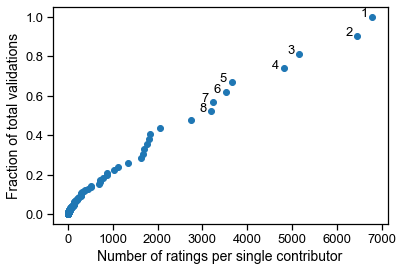

In [103]:
# Empirical cumulative distribution with the top-8 most active contributors highlighted
x = np.sort(coder_counts.classification_id.to_list())
y = np.cumsum(x) / len(batch_results)
plt.scatter(x, y, linewidths=1)

for j in range(0,8):
    plt.text(np.flip(x)[j]-270, np.flip(y)[j]+0.0, str(j+1))

plt.ylabel('Fraction of total validations')
plt.xlabel('Number of ratings per single contributor')
plotting_utils.export_figure(f'cumulative_ratings', figure_folder=figure_folder, png=True, svg=True)

plt.show()

# 5. Initial modelling

Model to predict transition feasibility

In [104]:
from sklearn.svm import SVR

In [105]:
df = df.set_index('subject_ids')
df = df.merge(batch_results.groupby('subject_ids')['feasibility_1-5'].std(),
              left_index=True, right_index=True)
df = df.rename(columns={'feasibility_1-5_x': 'feasibility_mean', 'feasibility_1-5_y': 'feasibility_std'})

### Simple Model - Linear Regression on Similarity Scores

In [106]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from yellowbrick.regressor import ResidualsPlot

In [107]:
train_cols = ['similarity_essential_skills',
              'similarity_optional_skills',
              'similarity_activities',
              'similarity_work_context']
test_col = 'feasibility_mean'

X_train, X_test, y_train, y_test = train_test_split(df[train_cols], df[test_col], random_state=0, test_size=0.2, train_size=0.8)

In [108]:
polynomial_features = PolynomialFeatures(degree=2)
regression = LinearRegression()
pipeline = Pipeline([
    ("polynomial_features", polynomial_features),
     ("regression", regression)])

In [109]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# The coefficients
print('Coefficients: \n', pipeline['regression'].coef_, '\n')
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Coefficients: 
 [ 0.         -0.52733524  4.92554933  0.28301375 -0.41067824 -2.8249002
  3.75605775 -0.19778286  0.87155751 -2.81238333 -0.64926257 -1.0754308
 -0.21252872  0.1963655   0.56507237] 

Mean squared error: 0.23
Coefficient of determination: 0.61


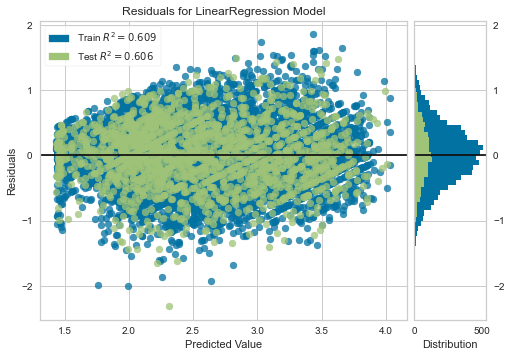

In [110]:
visualizer = ResidualsPlot(pipeline)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 
plt.show()

### 5.2 Support vector regression

In [111]:
svr = SVR(kernel='rbf', C=.1, gamma='auto', epsilon=0.5)

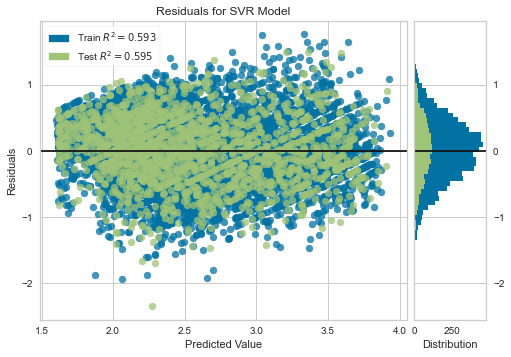

In [112]:
visualizer = ResidualsPlot(svr)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 
plt.show()

In [113]:
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)

# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, y_pred))

Mean squared error: 0.24
Coefficient of determination: 0.59
